# Neural Networks

Our task is to develop an algorithm capable of recognizing handwritten digits (0 to 9).

We have already experimented with this challenge with Regularized Logistic Regression getting a global model accuracy of around 76%. We are going to implement a NN end to end and see if we can beat the previous result. We will follow two steps:

1. Implement Forward Progragation and run a NN with pre-trained weights
2. Implement the whole algorithm, hence Forward Propagation (defining the relation between predictors and output) plus Back Propagation (which will enable us to learn the weights defined in the first step)

### NN Representation: Forward Propagation

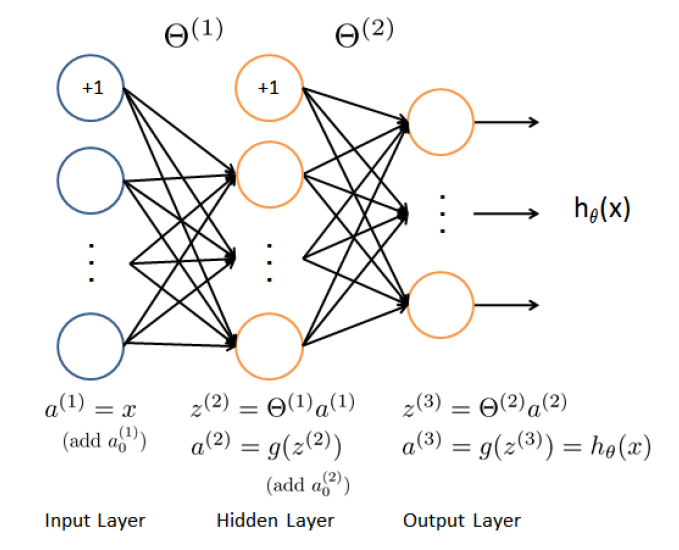

In [1]:
from IPython.display import Image
Image("C:\\Users\\pochetti\\Desktop\\Fra\\Francesco\\NN.png")

For point #1 we already have the optimized coefficients $\Theta$. Therefore we just implement the network, mapping inputs to outputs. In our specific case the input is a set of 20-by-20-pixels 5000 b&w images in the form of a 5000 by 400 matrix X. So the $i_{th}$ row of the matrix represents a flattened image where each column is one pixel.

The idea behind the NN visualized in the above image (taken from Andrew Ng's ML course on Coursera) is to introduce non linearity by adding intermediate steps between inputs (raw pixels) and outputs (probability of the image to show one of 10 digits from 0 to 9). Therefore the complexity does not reside in the function applied to the input but rather on generating multiple hidden layers to which other functions are applied until the "brain" is articulated enough to "figure out" a plausible output. The power of the model is that it moves a significant part of the non linearity burden to the depth of the network reducing the complexity of the actual mathematical functions mapping one layer to the next. 

 We are going to use sigmoids to bridge the 3 layers.

In [2]:
import scipy.io
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Functions 

In [22]:
def displayData(X, how_many):
    fig = plt.figure(figsize=(9,9))
    #plt.title('100 Random Images from the data set')
    indexes = random.sample(range(0, X.shape[0]), how_many)
    images = X[indexes,:]
    square = np.sqrt(how_many)
    for i in np.arange(square):
        for j in np.arange(square):
            ax = fig.add_subplot(square, square, (square*j+i)+1)
            ax.matshow(images[square*j+i,:].reshape(20,20), cmap = 'gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()
    
def displayPredictions(X, y, predictions):
    fig = plt.figure(figsize=(9,9))
    plt.title('100 Random Images; NN predictions in Red; Actuals in Blue', y=1.04)
    indexes = random.sample(range(1, X.shape[0]), 100)
    images = X[indexes,:]
    pred = predictions[indexes]
    actuals = y[indexes]
    for i in np.arange(10):
        for j in np.arange(10):
            ax = fig.add_subplot(10, 10, (10*j+i)+1)
            ax.matshow(images[10*j+i,:].reshape(20,20), cmap = 'gray')
            ax.annotate(pred[10*j+i], xy=(2, 1), color='r', weight='bold', size=14,
                        horizontalalignment='right', verticalalignment='bottom')
            ax.annotate(actuals[10*j+i][0], xy=(11, 1), color='b', weight='bold', size=14,
                        horizontalalignment='right', verticalalignment='bottom')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.tight_layout()
    plt.show()

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def forwardPropagation(InputHidden, HiddenOutput, X):
    # X should be passed with the intercept already added
    hidden =  sigmoid(X.dot(InputHidden.T)) # <5000*401><401*25> = <5000*25>
    hidden =  np.c_[np.ones(hidden.shape[0]), hidden] # <5000*26> adding intercept
    output = sigmoid(hidden.dot(HiddenOutput.T)) # <5000*26><26*10> = <5000*10>
    
    return output

### Visualizing the data

100 Random images from the training set


c:\users\pochetti\appdata\local\continuum\anaconda\envs\foodproject\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


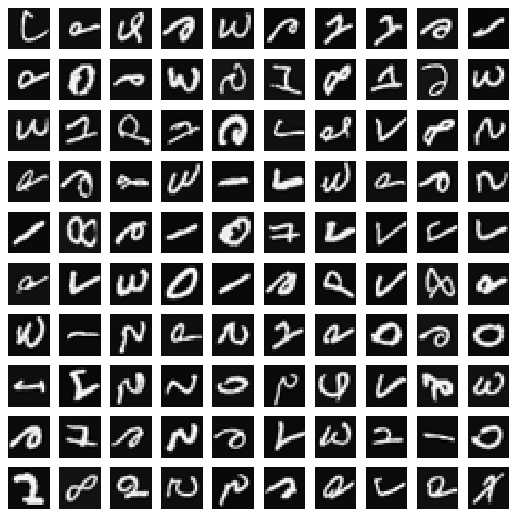

In [4]:
mat = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex3-005\\mlclass-ex3\ex3data1.mat')
X = mat['X']
y = mat['y']

print('100 Random images from the training set')
displayData(X, 100)

### Running a pre-trained NN 

In [5]:
mat = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex3-005\\mlclass-ex3\ex3data1.mat')
X = mat['X']
y = mat['y']

weights = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex3-005\\mlclass-ex3\ex3weights.mat')
InputHidden = weights['Theta1']
HiddenOutput = weights['Theta2']

X =  np.c_[np.ones(X.shape[0]), X] # adding intercept to X

probabilities_pretrained = forwardPropagation(InputHidden, HiddenOutput, X)

predictions_pretrained = np.argmax(probabilities_pretrained, axis=1) + 1

accuracy_pretrained = (y == predictions_pretrained.reshape(-1,1)).mean()*100

print('NN Accuracy: {0}%'.format(round(accuracy_pretrained, 2)))

NN Accuracy: 97.52%


###  Visualizing data and predictions

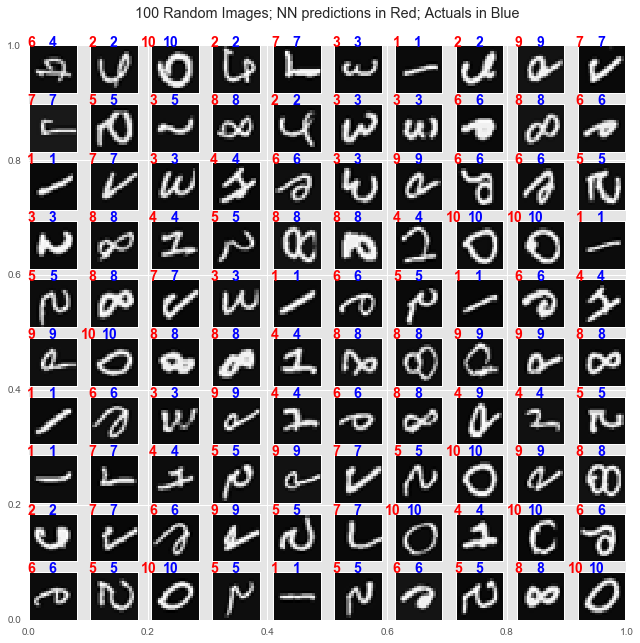

In [6]:
mat = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex3-005\\mlclass-ex3\ex3data1.mat')
X = mat['X']
y = mat['y']

displayPredictions(X, y, predictions_pretrained)

## Learning a Neural Network: Optimizing Cost via Backpropagation 

Let's define some variables first:
1. $L$ = number of layers
2. $s_l$ = number of neurons (nodes) in the $l_{th}$ layer not counting the bias unit
3. $K$ = number of classes, $S_L = K$
4. $m$ = number of data points (row) in the training set
5. $n$ = number of features (columns in the training sets)

Second, let's recall the cost function for logistic regression

$J(\theta) = -\frac{1}{m}\sum_{t=1}^m(y_t log(h_t(\theta)) + (1-y_t)log(1-h_t(\theta))) + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$

Considering that we use sigmoids as activation functions for our neurons, the cost for the NN is going to be just a more complicated version of the above:

$J(\Theta) = -\frac{1}{m}\sum_{t=1}^m \sum_{k=1}^K\big[y_k^{(t)} log(h_k(\Theta)^{(t)}) + (1-y_k^{(t)})log(1-h_k(\Theta)^{(t)})\big] + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_l + 1}(\Theta_{i,j}^{(l)})^2$

where $h_k(\Theta)^{(t)}$ is the value of the output function for the $t_{th}$ training point for the $k_{th}$ class.

In our digit recognition example $h_k(\Theta)^{(t)}$ is the result of the forward propagation applied on the $t_{th}$ image in the $5000 \times 400$ $X$ input matrix, nothing else than $a^{(3)} = g(z^{(3)}) = g(\Theta^{(2)} a^{(2)}) = h(\Theta)$ (see image on top).

We want to find $\Theta$ to minimize $J(\Theta)$. To do that we need to calculate $\nabla J(\Theta)$ w.r.t. to $\Theta$, basically $\frac{\partial J(\Theta)}{\partial \Theta_{i,j}^{(l)}} = D_{i,j}^{(l)}$

The backpropagation algorithm helps us to calculate $D_{i,j}^{(l)}$

Given a training set $ \{(x^{(1)}, y^{(1)}) ... (x^{(m)}, y^{(m)}) \}$ where $X \in \mathcal{R}^{m \times n}$

1. $\Delta_{i, j}^{(l)} := 0$ for all $(i, j)$ nodes in the $l$ layers in the network. This matrix will be used to store the gradient of the cost function
2. For $i = 1:m$ (looping through the training set):
    1. Set $a^{(1)} := x^{(i)}$ where $a^{(1)}$ is the first layer
    2. Perform forward propagation to compute $a^{(l)}$ for  $l = 2,3,...,L$ where $a^{l} = g(z^{l})$ and $z^{l} = \Theta^{l-1}a^{l-1}$. NB: $g$ is the activation function, in our case a sigmoid; always add the bias term $a^{l}_0$ of ones to account for the intercept.
    3. Using $y^{i}$, compute $\delta^{L} = a^{L} - y^{i}$, where $\delta^{L}$ can be interpreted as the error term within the last layer of the network, calculated w.r.t to the final output.
    4. It can be shown that the error values for the previous layers (up to the second) is equal to (vectorized form) $\delta^{(l)} = \delta^{(l-1)}\Theta^{(l)}g'(z^{(l)}) = \delta^{(l+1)}\Theta^{(l)} a^{(l)} (1-a^{(l)})$
    5. $\Delta_{i, j}^{(l)} := \Delta_{i, j}^{(l)} + a^{(l)}_j \delta^{(l+1)}_i$
3. $D_{i,j}^{(l)} := \frac{1}{m}(\Delta_{i,j}^{(l)} + \lambda\Theta_{i,j}^{(l)})$ if $j \neq 0$
4. $D_{i,j}^{(l)} := \frac{1}{m}\Delta_{i,j}^{(l)}$ if $j = 0$ where $\frac{\partial J(\Theta)}{\partial \Theta_{i,j}^{(l)}} = D_{i,j}^{(l)}$

### BackProp Representation

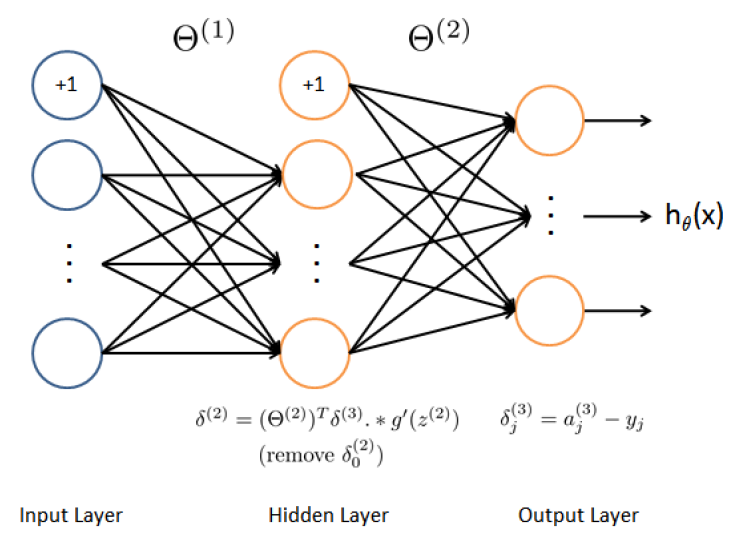

In [7]:
from IPython.display import Image
Image("C:\\Users\\pochetti\\Desktop\\Fra\\Francesco\\BackProp.png")

### Functions 

In [8]:
def nnForwardPropCost(nn_weights, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    '''Calculates the regularized cost function for a 3-layer NN'''
    
    y_new = np.zeros((y.shape[0], num_labels))
    for i in np.arange(y.shape[0]):
        y_new[i, y[i]-1] = 1    
    
    InputHidden = nn_weights[0:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
    HiddenOutput = nn_weights[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)
    
    X =  np.c_[np.ones(X.shape[0]), X] # adding intercept to X
    m = X.shape[0]
    
    z_2 = X.dot(InputHidden.T) # <5000,401><401,25> = <5000,25>
    a_2 = sigmoid(z_2) # <5000,25>
    a_2 = np.c_[np.ones(a_2.shape[0]), a_2] # <5000,26> adding intercept
    z_3 = a_2.dot(HiddenOutput.T) # <5000,26><26,10> = <5000,10>
    a_3 = sigmoid(z_3) # <5000,10>
    
    cost = 0
    for i in np.arange(X.shape[0]):
        # calculating cost for every image in the training set and summing up over all training set
        cost += -(1/m) * (np.log(a_3[i,:]).dot(y_new[i,:].T) + np.log(1-a_3[i,:]).T.dot((1-y_new[i,:]).T)) 
    
    regularization = lamb/(2*m) * ((InputHidden[:,1:]**2).sum() + (HiddenOutput[:,1:]**2).sum())  
    cost += regularization
    
    return np.asscalar(cost.squeeze())

def sigmoidGradient(z):
    '''Calculates the gradient of the sigmoid function'''
    return sigmoid(z) * (1 - sigmoid(z))

def randInitializeWeights(layer_l_size, layer_l_plus_one_size):
    '''Initializes the matrix of weights mapping layer l to l+1'''
    epsilon = np.sqrt(6)/(np.sqrt(layer_l_size + layer_l_plus_one_size))
    
    return np.random.uniform(-epsilon, epsilon, (layer_l_plus_one_size, layer_l_size + 1))

def nnBackPropGradient(nn_weights, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    '''Calculates the gradient of the cost function w.r.t. the NN weights'''

    # dummifying output and reshaping it into a 5000x10 matrix
    y_new = np.zeros((y.shape[0], num_labels))
    for i in np.arange(y.shape[0]):
        y_new[i, y[i]-1] = 1
    
    InputHidden = nn_weights[0:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
    HiddenOutput = nn_weights[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)    
    
    #initializes the gradient of the cost w.r.t the weights mapping first and second layer
    delta_1 = np.zeros((hidden_layer_size, input_layer_size+1))
    #initializes the gradient of the cost w.r.t the weights mapping second and third layer
    delta_2 = np.zeros((num_labels, hidden_layer_size+1))

    X =  np.c_[np.ones(X.shape[0]), X] # adding intercept to X now shaped <5000, 401>
    m = X.shape[0] # 5000
        
    z_2 = InputHidden.dot(X.T) # <25,5000> = <25,401>*<401,5000>
    a_2 = sigmoid(z_2) # <25,5000>
    a_2 = np.vstack((np.ones(a_2.shape[1]), a_2)) # <26,5000> adding intercept
    z_3 = HiddenOutput.dot(a_2) # <10,26><26,5000> = <10,5000>
    a_3 = sigmoid(z_3) # <10,5000>

    for i in np.arange(X.shape[0]):
        #Perform a feedforward pass computing the activations (z(2); a(2); z(3); a(3)) for layers 2 and 3.
        a_1i = X[i,:].T # <401,>
        z_2i = z_2[:,i] # <25,>
        a_2i = a_2[:,i] # <26,>
        z_3i = z_3[:,i] # <10,>
        a_3i = a_3[:,i] # <10,>
        y_i = y_new[i,:].T # <10,>
        
        #For each output unit k in layer 3 (the output layer), set_k(3) = (a_k(3) - y_k)
        delta_3i = a_3i - y_i # <10,>
    
        #third passage
        delta_2i = HiddenOutput.T.dot(delta_3i)*sigmoidGradient(np.append(np.ones(1), z_2i)) # <26,> = <26,10>*<10,>.*<26,>
        
        #accumulate the gradient
        delta_1 += delta_2i[1:].reshape(-1,1).dot(a_1i.reshape(-1,1).T) # <25,401> = <25,1>*<1,401>

        delta_2 += delta_3i.reshape(-1,1).dot(a_2i.reshape(-1,1).T) # <10,26> = <10,1>*<1,26>

    #InputHidden[:, 0] = 0
    #HiddenOutput[:, 0] = 0
    
    InputHidden_grad = (1/m)*delta_1 + lamb/m * InputHidden
    HiddenOutput_grad = (1/m)*delta_2 + lamb/m * HiddenOutput

    grad = np.vstack((InputHidden_grad.reshape(InputHidden_grad.size, 1), 
                      HiddenOutput_grad.reshape(HiddenOutput_grad.size, 1)))
    
    return grad.flatten()

def checkNNgradients(lamb):
    '''
    CHECKNNGRADIENTS Creates a small neural network to check the backpropagation gradients.
    Creates a small neural network to check the backpropagation gradients, it will output the analytical gradients
    produced by the backprop code and the numerical gradients (computed using computeNumericalGradient). 
    These two gradient computations should result in very similar values.
    '''
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    theta = np.vstack((Theta1.reshape(Theta1.size, 1), Theta2.reshape(Theta2.size, 1)))
    
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = (1 + np.mod(np.arange(m)+1, num_labels).T).reshape(-1, 1) # array([2, 3, 1, 2, 3], dtype=int32)  
    
    grad = nnBackPropGradient(theta, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
    numgrad = computeNumericalGradient(nnForwardPropCost, theta, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
    
    return numgrad, grad
    

def debugInitializeWeights(fan_out, fan_in):
    '''DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
    incoming connections and fan_out outgoing connections using a fixed
    strategy, this will help you later in debugging
    W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
    of a layer with fan_in incoming connections and fan_out outgoing 
    connections using a fix set of values

    Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
    the first row of W handles the "bias" terms'''

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in))

    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.sin(np.arange(W.size)+1).reshape(W.shape[0], W.shape[1]) / 10
    
    return W

def computeNumericalGradient(J, theta, input_layer_size, hidden_layer_size, num_labels, X, y, lamb):
    '''COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
        and gives us a numerical estimate of the gradient.
        numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
        gradient of the function J around theta. Calling y = J(theta) should
        return the function value at theta.

     Notes: The following code implements numerical gradient checking, and 
            returns the numerical gradient.It sets numgrad(i) to (a numerical 
            approximation of) the partial derivative of J with respect to the 
            i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
            be the (approximately) the partial derivative of J with respect 
            to theta(i).)'''
                
    numgrad = np.zeros((theta.shape[0], 1))
    perturb = np.zeros((theta.shape[0], 1))
    e = 1e-4
    for p in np.arange(theta.size):
        # Set perturbation vector
        perturb[p] = e
        loss1 = J(theta - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
        loss2 = J(theta + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
        
    return numgrad

### Loading data and checking cost

In [9]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10  

mat4 = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex4-005\\mlclass-ex4\ex4data1.mat')
X = mat4['X']
y = mat4['y']

weights = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex4-005\\mlclass-ex4\ex4weights.mat')
InputHidden = weights['Theta1']
HiddenOutput = weights['Theta2']

nn_weights = np.vstack((InputHidden.reshape(InputHidden.size, 1), HiddenOutput.reshape(HiddenOutput.size, 1)))

# dummifying output and reshaping it into a 5000x10 matrix
y_new = np.zeros((y.shape[0], num_labels))
for i in np.arange(y.shape[0]):
    y_new[i, y[i]-1] = 1

print('Size of the input matrix (20x20 pixels images):', X.shape)
print('Size of the output vector y:', y.shape)
print('Size of dummified matrix y_new:', y_new.shape)
print('\n')
print('A few examples of how dummification works')
print('100th row in y:', y[100])
print('100th row in y_new:', y_new[100,:])
print('1000th row in y:', y[1000])
print('1000th row in y_new:', y_new[1000,:])
print('2000th row in y:', y[2000])
print('2000th row in y_new:', y_new[2000,:])
print('3000th row in y:', y[3000])
print('3000th row in y_new:', y_new[3000,:])
print('\n')
print('Size of the matrix of weights mapping first and second layer:', InputHidden.shape)
print('Size of the matrix of weights mapping second and third layer:', HiddenOutput.shape)

Size of the input matrix (20x20 pixels images): (5000, 400)
Size of the output vector y: (5000, 1)
Size of dummified matrix y_new: (5000, 10)


A few examples of how dummification works
100th row in y: [10]
100th row in y_new: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
1000th row in y: [2]
1000th row in y_new: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
2000th row in y: [4]
2000th row in y_new: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
3000th row in y: [6]
3000th row in y_new: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


Size of the matrix of weights mapping first and second layer: (25, 401)
Size of the matrix of weights mapping second and third layer: (10, 26)


In [10]:
# calculating un-regularized cost for the Neural Network
lamb = 0
cost = nnForwardPropCost(nn_weights, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
print('Cost for the un-regularized (lambda = 0) pre-trained NN:', cost)

Cost for the un-regularized (lambda = 0) pre-trained NN: 0.28762916516131865


In [11]:
# calculating regularized cost for the Neural Network
lamb = 1
cost = nnForwardPropCost(nn_weights, input_layer_size, hidden_layer_size, num_labels, X, y, lamb)
print('Cost for regularized (lambda = 1) pre-trained NN:', cost)

Cost for regularized (lambda = 1) pre-trained NN: 0.38376985909092337


### Initializing NN weights

A very important step before even start running any optimization algortithm is to randomly intialize the matrices of weights to be learnt. An effective strategy is to select values for $\Theta^{(l)}$ which are uniformly distributed in the range $[-\epsilon^{(l)}_{init}, \epsilon^{(l)}_{init}]$

A good choice of $\epsilon^{(l)}_{init}$ is $\epsilon^{(l)}_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$

In [12]:
InputHiddenInit = randInitializeWeights(input_layer_size, hidden_layer_size)
HiddenOutputInit = randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_weights = np.vstack((InputHiddenInit.reshape(InputHiddenInit.size, 1), 
                                HiddenOutputInit.reshape(HiddenOutputInit.size, 1)))

print('Size of the initialized matrix of weights mapping first and second layer:', InputHiddenInit.shape)
print('Size of the initialized matrix of weights mapping second and third layer:', HiddenOutputInit.shape)

Size of the initialized matrix of weights mapping first and second layer: (25, 401)
Size of the initialized matrix of weights mapping second and third layer: (10, 26)


### Checking gradient implementation 

In our neural network, we are minimizing the cost function $J(\Theta)$. To perform gradient checking on our parameters, we can imagine "unrolling" the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, we can think of
the cost function being $J(\theta)$ instead and use the following gradient checking procedure.

Suppose we have a function $f_i(\theta)$ that purportedly computes $\frac{\partial J(\Theta)}{\partial \theta_{i}}$; we'd like to check if $f_i$ is outputting correct derivative values.

Let $\theta^{(i+)} = \theta + \begin{bmatrix} 0 \\0 \\ \vdots \\ \epsilon \\ \vdots \\0 \\0 \end{bmatrix}$ and $\theta^{(i-)} = \theta - \begin{bmatrix} 0 \\0 \\ \vdots \\ \epsilon \\ \vdots \\0 \\0 \end{bmatrix}$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i-th$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i-)}$  is the corresponding vector with the $i-th$ element decreased by $\epsilon$. We can now numerically verify $f_i(\theta)$'s correctness by checking, for each $i$, that:

$f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4} $, we'll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more). If our backpropagation implementation is correct, we should see a relative difference that is less than $10^{-9}$.

In [34]:
lamb = 1
numgrad, grad = checkNNgradients(lamb)

rel_dif = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

print("Relative difference between cost's gradient calculated numerically (numgrad) and analytically (grad):", rel_dif)

Relative difference between cost's gradient calculated numerically (numgrad) and analytically (grad): 0.718362905292


The above delta should be much smaller. I am currently checking for specific bugs in the implementation of the gradient.

### Minimizing cost using backprop

In [24]:
import time

input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10  

mat4 = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex4-005\\mlclass-ex4\ex4data1.mat')
X = mat4['X']
y = mat4['y']

start = time.time()

lamb = 2
opt_results = scipy.optimize.fmin_cg(f=nnForwardPropCost, x0=initial_nn_weights.squeeze(), 
                                     args=(input_layer_size, hidden_layer_size, num_labels, X, y, lamb),
                                     fprime=nnBackPropGradient, disp=True, full_output=True, retall=True)

end = time.time()

Optimization terminated successfully.
         Current function value: 0.461087
         Iterations: 1104
         Function evaluations: 2924
         Gradient evaluations: 2924


In [28]:
total = end-start
print("NN Training executed in", round(total/60, 2), "minutes")

NN Training executed in 33.77 minutes


### Performance of trained Neural Network 

In [29]:
optimized_nn_weights = opt_results[0]

mat4 = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex4-005\\mlclass-ex4\ex4data1.mat')
X = mat4['X']
y = mat4['y']

InputHidden = optimized_nn_weights[0:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1)
HiddenOutput = optimized_nn_weights[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1)

X =  np.c_[np.ones(X.shape[0]), X] # adding intercept to X

probabilities = forwardPropagation(InputHidden, HiddenOutput, X)

predictions = np.argmax(probabilities, axis=1) + 1

accuracy = (y == predictions.reshape(-1,1)).mean()*100

print('NN Accuracy: {0}%'.format(round(accuracy, 2)))

NN Accuracy: 98.48%


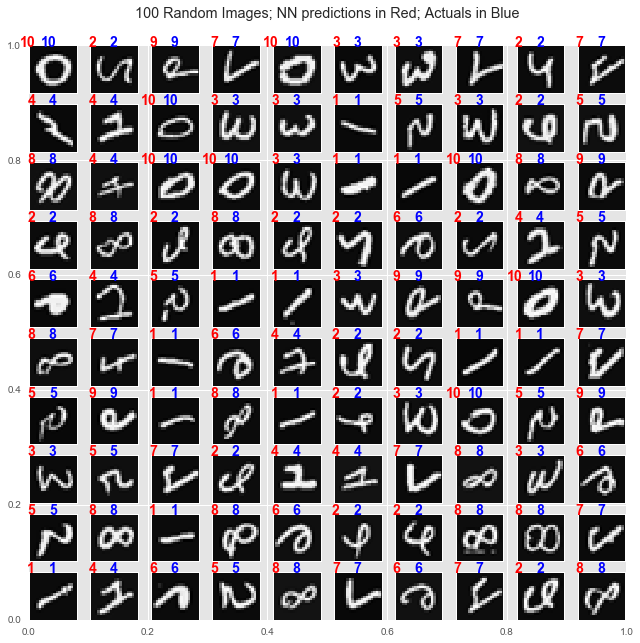

In [19]:
mat4 = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex4-005\\mlclass-ex4\ex4data1.mat')
X = mat4['X']
y = mat4['y']

displayPredictions(X, y, predictions)

### Display Hidden Layer 

One way to understand what our neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input x that will cause it to activate (that is, to have an activation value ($a_i^{(l)}$ close to 1). For the neural network we trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the "representation" captured by the hidden unit is to reshape this 400 dimensional vector into a $20 \times 20$ image and display it. The result is shown below in an image with 25 units, each corresponding to one hidden unit in the network. In our trained network, we should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

c:\users\pochetti\appdata\local\continuum\anaconda\envs\foodproject\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


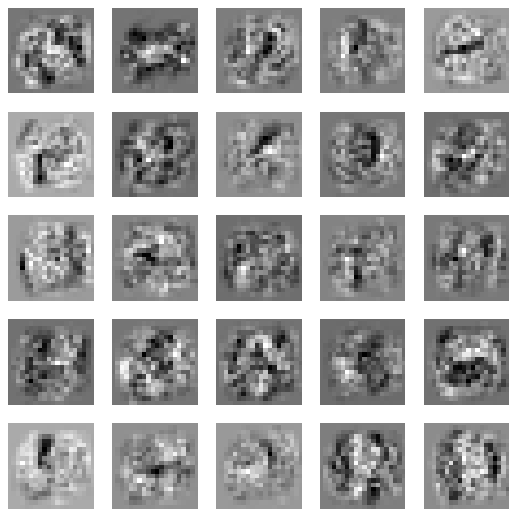

In [23]:
displayData(InputHidden[:,1:], 25)